# Project 1: MinHash and finding similar items

## Part 1: Jaccard Similarity and Shingles

In [1]:
# this piece of code is here to help wiht development using python module `plagiarism_lib`
%load_ext autoreload
%autoreload 2

The `plagiarism_lib` module includes a function to shingle documents. Here is an example of how to use it:

In [2]:
import plagiarism_lib.article_db as art_db

shingles = art_db._shingle_text('The cat in the hat', 2)
print(shingles)

{'ca', 'ha', 'th', 'in', 'he', 'eh', 'ti', 'nt', 'ec', 'at'}


Use this function to answer the following questions

In [3]:
# question 1: What is the jaccard similarity of these two sentences using 2-shingles:
s1 = "I would drink black tea"
s2 = "I would drink green tea"

sh1 = art_db._shingle_text(s1, 2)
sh2 = art_db._shingle_text(s2, 2)

len(sh1.intersection(sh2)) / len(sh1.union(sh2))

0.4782608695652174

In [4]:
# question 2: What is the jaccard similarity of these two sentences using 2-shingles:
s1 = "I would drink green tea but I would not drink black tea"
s2 = "I would not drink green tea but I would drink black tea"

sh1 = art_db._shingle_text(s1, 2)
sh2 = art_db._shingle_text(s2, 2)

len(sh1.intersection(sh2)) / len(sh1.union(sh2))

1.0

In [5]:
# question 3, what is the smallest shingle length we need to use 
# to distinguish these two sentences
for k in range(2, len(s1)):
  sh1 = art_db._shingle_text(s1, k)
  sh2 = art_db._shingle_text(s2, k)

  coef = len(sh1.intersection(sh2)) / len(sh1.union(sh2))
  if coef != 1:
    break

print(k)

7


## Fetch data

Run the following piece of code to fetch data to use in the project, and to setup experiment code

In [6]:
import plagiarism_lib.fetch_data as fetch
import plagiarism_lib.jaccard_experiment as jaccard_exp

import pandas as pd

In [7]:
# fetch small dataset from data repository
DATA_PATH = 'data'

fetch.fetch_data(path=DATA_PATH, maxsize=1000)

In [8]:
DATA_PATH = 'data'
train_file = DATA_PATH + '/articles_1000.train'
truth_file = DATA_PATH + '/articles_1000.truth'

import os

RESDIR_PATH = 'result_data'
if not os.path.isdir(RESDIR_PATH):
    os.mkdir(RESDIR_PATH)
    
jaccard_exp_csv = RESDIR_PATH + '/jaccard_exp_res.csv'

## Jaccard similarity

**TODO** Finish implementing the function `plagiarism_lib.jaccard._jaccard_similarity` to compute the Jaccard Similarity of two sets.

Once you do that run the next chunk to perform an experiment on the effect of shard-length $k$ on Jaccard similarity of
plagiarism instances versus instances that are not plagiarized.

Make sure you set `RUN_JACCARD_EXP = True` to get your experiment data


In [9]:
# run this if needed
RUN_JACCARD_EXP = True
if RUN_JACCARD_EXP:
    exp_res = jaccard_exp.run_experiment(train_file, truth_file)
    exp_res.to_csv(jaccard_exp_csv, index=False)
else:
    exp_res = pd.read_csv(jaccard_exp_csv)

Processing data for k= 2
Processing data for k= 5
Processing data for k= 10
Processing data for k= 20
Processing data for k= 40
Processing data for k= 60
Processing data for k= 120


The following code makes a plot with $k$ in the x-axis and average Jaccard similarity in the y-axis with two lines:
one for plagiarism instances, one for instances that are not plagiarism.

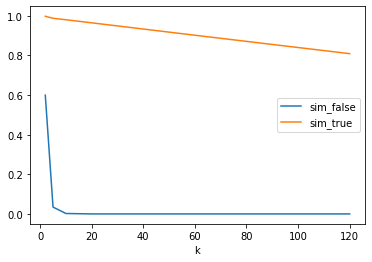

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt

# start here just to make plot
plot_df = exp_res.melt(id_vars=['k'])

fig, ax = plt.subplots()
labels = []

for key, grp in plot_df.groupby('variable'):
    ax = grp.plot(ax=ax, kind='line', x='k', y='value')
    labels.append(key)
lines, _ = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')
plt.show()

**TODO**: Comment on what you observe from this experiment.

We can observer from this experiment that jaccard similarity gets more distinguished as the shingle length increases.

## Part 2: MinHash and Jaccard Similarity

Load article data, preprocess it and shingle articles with length $k=10$



In [11]:
from plagiarism_lib.article_db import ArticleDB

artdb = ArticleDB(train_file)
exp_data = artdb.shingle_data(k=10)

Compute Jaccard similarities for pairs of articles in corpus. Set `RUN_MAKE_JS_DF=True` to prepare data on Jaccard similarity for our experiment.

In [12]:
import plagiarism_lib.minhash_experiment as minhash_exp
import pandas as pd

js_csv_file = RESDIR_PATH + '/js_df.csv'

# Switch True/False to run as needed
RUN_MAKE_JS_DF = False

if RUN_MAKE_JS_DF:
    exp_df = minhash_exp.make_js_df(exp_data, artdb._docids)
    exp_df.to_csv(js_csv_file, index=False)
else:
    exp_df = pd.read_csv(js_csv_file)

**TODO**: Finish implementing function `plagiarism_lib.minhash._make_minhash_sigmatrix` to construct the minhash signature matrix of the document collection.

**TODO**: Finish implementing function `plagiarism_lib.minhash.MinHash.get_similarity` to compute the minhash estimate of Jaccard similarity given two minhash signatures.

Once you have completed the above todos, let's compute minhash similarity matrices with varying number of hash functions and compute Jaccard similarity estimates. Set `RUN_MAKE_MH_DF=True` and run the following chunk.

In [13]:
mh_csv_file = RESDIR_PATH + '/mh_df.csv'

hash_vals = [10, 20, 50, 100, 1000]
RUN_MAKE_MH_DF = False
if RUN_MAKE_MH_DF:
    minhash_exp.run(exp_data, exp_df, hash_vals=hash_vals)
    exp_df.to_csv(mh_csv_file, index=False)
else:
    exp_df = pd.read_csv(mh_csv_file)

The following chunk computes the error of minhash similarity estimates. We are going to use that to see what the effect of the number of hashes used in the minhash signature affects the error of the MinHash estimate of Jaccard similarity.


In [14]:
rmse_df = minhash_exp.post_process_df(exp_df, hash_vals)

The following chunk plots root mean squared error between minhash JS estimate and exact Jaccard similarity

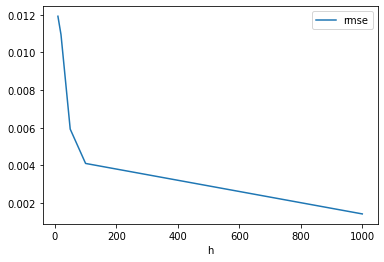

In [15]:
%matplotlib inline

import matplotlib.pyplot as plt


#fig, ax = plt.subplots()
rmse_df.plot(x='h',y='rmse')#, ax=ax)
plt.show()

**TODO**: Comment on the effect of the number of hashes used in the minhash signature matrix and the error of the MinHash estimate.

We can observe that the bigger the length of signatures, the more accurate the similarities.

## Part 3: LSH

Prepare article database for training file, using $k=10$ for shingles

In [16]:
import plagiarism_lib.lsh_experiment as lsh_exp
from plagiarism_lib.article_db import ArticleDB
from plagiarism_lib.minhash import invert_shingles, MinHash
from pathlib import Path

numdocs = 1000
trainfile = DATA_PATH + '/articles_%d.train' % numdocs

k = 10
print("Preparing Data")
artdb = ArticleDB(trainfile)
inv_data, docids = invert_shingles(artdb.shingle_data(k))

Preparing Data


Compute the minhash signature matrix with 100 rows (hash functions)

In [17]:
num_hash = 100
mh_mat_file = RESDIR_PATH + '/mh_mat_%d_%d_%d.npy' % (numdocs, k, num_hash)

mh = MinHash(num_hash)
if Path(mh_mat_file).is_file():
    print("Loading MH signature matrix from file")
    mh.from_file(docids, mh_mat_file)
else:
    print("Creating minhash matrix with %d hashes" % num_hash)
    mh.make_matrix((inv_data, docids), inverted=True) 
    mh.save_matrix(mh_mat_file)

Loading MH signature matrix from file


**TODO**: Finish implementing function `plagiarism_lib.lsh._do_lsh` to implement Locality Sensitive Hashing.

Once that is done, run an experiment of using LSH with desired similarity threshold values to detect plagiarism. Set `RUN_LSH_EXP=True` and run the following chunk.

In [18]:
import plagiarism_lib.lsh_experiment as lsh_exp

DEFAULT_TS = [.01, .05, .10, .30, .50, .70, .90, .95, .99]

truthfile = DATA_PATH + '/articles_%d.truth' % numdocs

lsh_csv_file = RESDIR_PATH + '/lsh_df.csv'

RUN_LSH_EXP = False
if RUN_LSH_EXP:  
    exp_df = lsh_exp.run(mh, truthfile, ts=DEFAULT_TS)
    exp_df.to_csv(lsh_csv_file, index=False)
else:
    exp_df = pd.read_csv(lsh_csv_file)

The following chunk plots precision and recall of this system as a function of the LSH threshold chosen. 

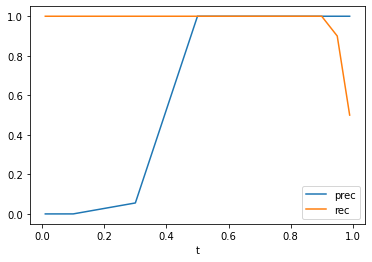

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

plot_df = exp_df.melt(id_vars=['t'])

fig, ax = plt.subplots()
labels = []

for key, grp in plot_df.groupby('variable'):
    ax = grp.plot(ax=ax, kind='line', x='t', y='value')
    labels.append(key)
lines, _ = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')
plt.show()

**TODO**: Comment on the behavior of precision and recall as a function of similarity threshold. 

We can notice that the precision and similarity are maximized staring from over 0.5 of threshold